# Real Data Analysis

For our real data, we will attempt to cluster functional connectomes. Here, we will define a connectome as follows:

\begin{align*}
    C_{ij} = cor(T_i, T_j)
\end{align*}

Where $T_i$ represents the $i^{th}$ timeseries of the downsampled functional MR scan. The graphs timeseries were acquired as follows:

1. Preprocess the scans.
    + Motion correction: estimate a $6$ DOF affine transformation between the first timepoint and the rest of the timepoints. Apply the transformation to the data, removing inter-scan motion in the process. We know this will reduce motion since the subjects only have $6$ degrees of freedom to move their heads in the scanner (x, y, z, and rotations of all 3).
    + Slice timing correction: estimate the delay between 2d scans acquired per volume. The entire 3d volume is acquired as a rapid acquisition of 2d slices per timepoint for a single volume. Slice timing correction interpolates the timeseries to remove distortions introduced.
2. Register the scans to a common template.
    + Self Registration: Align the functional scan to the corresponding anatomical scan provided with each subject using epi-registration.
    + Template Registration: Align the anatomical scan for a subject to the template image. The template is a "brain average" of many subjects, and allows us to use common reference points in the voxel-space of the brain between individual subjects. We use the anatomical scan here because it is far higher resolution than the functional image. Apply the estimated nonlinear transform to the self-registered functional scan. Basically, each subject has a different size brain, and template registration allows us to standardize brain shape. 
3. Perform Nuisance Correction.
    + Estimate the top 5 PCs from the white matter regions in the brain. The idea here is that white matter voxels are mostly axons, and not cell bodies, so we would not expect to have much task-related activity here compared to the gray matter (which is where most cell bodies live). 
    + Perform frequency filtering, if desired. The idea here is that brain signal is on the order of 0.1 Hz, so we bandpass above 1 Hz and below 0.01 Hz to remove noise outside of this range.
    + Perform quadratic drift removal. As a scanner heats up, the intensities are known to drift quadratically. As the brain signal is the shape of a hemodynamic response function, and not a quadratic, we can fit the best-fit quadratic to the data and remove it without losing brain signal.
4. Timeseries Estimation
    + Take a labelled parcellation in the template space that we registered to. Take the spatial mean per time point of all the voxels within a region of interest in the parcellation file. Report the timeseries. 

The data used for the purposes of this project was estimated with [CPAC](http://fcp-indi.github.io/docs/user/). For a more detailed look at the above steps, see the schematic Eric is preparing for his thesis building a similar pipeline [here](https://neurodatadesign.github.io/fngs/ewalke31/tutorials/week_0410/Schematic.html). Note that the image is clickable for each step. 

To download the data used below, issue the following commands:

```
wget -r http://openconnecto.me/mrdata/share/fmri/cpacv0392/HNU1/graphs/FSL_nff_nsc_ngs_aal/
wget -r http://openconnecto.me/mrdata/share/fmri/cpacv0392/HNU1/graphs/FSL_frf_nsc_ngs_aal/
```

and move them somewhere appropriately.


In [20]:
%matplotlib inline
import numpy as np
from clustering import Kmeans, Spectral
from clustering.kernel import RBF_kernel
from clustering.utils import purity, plot_laplacian
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os.path as op
from os import listdir
import re


def get_graphs(directory, sub_loc, ses_loc):
    """
    A function to retrieve the graphs given a populated input directory.
    
    **Positional Arguments:**
        - directory:
            - the directory in which the graphs are downloaded.
        - sub_loc:
            - the index in which the subject ids are recorded in the file name.
                for example, if the filename structure is:
                dataset_00234899_session1_correlation.graphml
                sub_loc would be 1.
        - ses_loc:
            - the index of the session number for a given subject. in the above example,
                this would be 2.
    """
    graphs = []
    subs = []
    sessions = []
    for f in listdir(directory):
        fname = op.join(directory, f)
        if op.isfile(fname):
            try:
                graphs.append(nx.to_numpy_matrix(nx.read_graphml(fname)))
                split_name = re.split('_|-', fname)
                subs.append(split_name[sub_loc])
                sessions.append(split_name[ses_loc])
            except:
                print ('failed to load: {}'.format(fname))
    data_mtx = np.asarray(graphs)
    data_mtx = np.swapaxes(data_mtx, 0, 2)
    return (data_mtx, subs, sessions)

directory = '/data/project/filtered'
(graphs, subs, sessions) = get_graphs(directory, 1, 2)



(116, 116, 300)


/home/eric/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


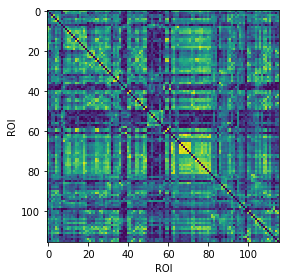

In [21]:
# visualize a correlation matrix to make sure they are valid
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(graphs[:,:,0])
ax.set_xlabel('ROI')
ax.set_ylabel('ROI')
fig.tight_layout()
fig.show()